In [1]:
import pandas as pd
import numpy as np

from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from utils.dataset import FeatureCaptionDataset
from utils.models import CNNEncoder, RNNDecoder
from utils.helpers import get_tokenizer_vocab, collate_fn_pad, show_image, plot_attention
from utils.trainer import Trainer

In [2]:
PATH = "dataset/"

In [3]:
df = pd.read_csv(PATH + "captions.txt")

In [4]:
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


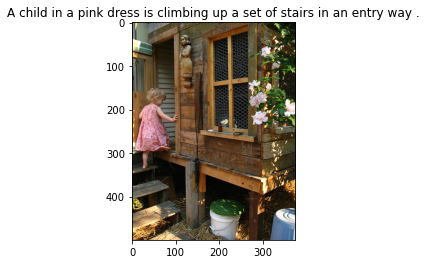

In [5]:
idx = 0
sample_image = Image.open(PATH + "Images/" + df.image[idx])
image_arr = np.asarray(sample_image)
show_image(image_arr, df.caption[idx])

In [6]:
sample_features = np.load(PATH + "embeddings/" + df.image[idx] + ".npy")

In [7]:
tokenizer, vocab = get_tokenizer_vocab(df)

In [8]:
dataset = FeatureCaptionDataset(PATH + "embeddings/", df, tokenizer, vocab)

In [9]:
(
    encoder_dim,
    decoder_dim,
    attention_dim,
    embed_dim,
    vocab_size,
    epochs,
    batch_size,
    attention_feature_shape,
    inception_features
) = (256, 512, 512, 256, len(vocab), 20, 64, 8 * 8, 1536)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn_pad, num_workers=4, shuffle=True)
len(dataloader)

633

In [11]:
# max_len = 0
# for i in tqdm(range(len(dataset))):
#     _, cap = dataset[i]
#     cap_len = len(cap)
#     if cap_len > max_len:
#         max_len = cap_len
max_len = 42

In [12]:
wandb_config = {
    "encoder_dim": encoder_dim, "decoder_dim": decoder_dim, 
    "attention_dim": attention_dim, "embed_dim": embed_dim,
    "vocab_size": vocab_size, "max_len": max_len,
    "epochs": epochs, "batch_size": batch_size,
    "inception_features": inception_features, "attention_feature_shape": attention_feature_shape
}

In [13]:
encoder = CNNEncoder(inception_features, encoder_dim)

In [14]:
decoder = RNNDecoder(encoder_dim=encoder_dim, 
                     decoder_dim=decoder_dim, 
                     attention_dim=attention_dim, 
                     embedding_dim=embed_dim, 
                     vocab_size=vocab_size
                    )

In [15]:
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
ce_loss = nn.CrossEntropyLoss(reduction="none")

In [16]:
trainer = Trainer(encoder, decoder, optimizer, ce_loss, vocab, max_len, 
                  attention_feature_shape, device, "image-captioning", wandb_config, sample_image, sample_features
                 )

wandb: Currently logged in as: kad99kev (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


0it [00:00, ?it/s]

********** Epoch 1/20 **********
Total Loss: 1.876576
********** Epoch 2/20 **********
Total Loss: 1.529853
********** Epoch 3/20 **********
Total Loss: 1.396114
********** Epoch 4/20 **********
Total Loss: 1.298496
********** Epoch 5/20 **********
Total Loss: 1.214262
********** Epoch 6/20 **********
Total Loss: 1.139762
********** Epoch 7/20 **********
Total Loss: 1.079499
********** Epoch 8/20 **********
Total Loss: 1.023745
********** Epoch 9/20 **********
Total Loss: 0.964770
********** Epoch 10/20 **********
Total Loss: 0.912852
********** Epoch 11/20 **********
Total Loss: 0.870304
********** Epoch 12/20 **********
Total Loss: 0.826796
********** Epoch 13/20 **********


wandb: Network error resolved after 0:00:11.695171, resuming normal operation.


Total Loss: 0.791888
********** Epoch 14/20 **********
Total Loss: 0.759861
********** Epoch 15/20 **********
Total Loss: 0.730813
********** Epoch 16/20 **********
Total Loss: 0.701201
********** Epoch 17/20 **********
Total Loss: 0.676770
********** Epoch 18/20 **********
Total Loss: 0.655443
********** Epoch 19/20 **********
Total Loss: 0.637458
********** Epoch 20/20 **********


wandb: Network error resolved after 0:03:19.534053, resuming normal operation.


Total Loss: 0.616190


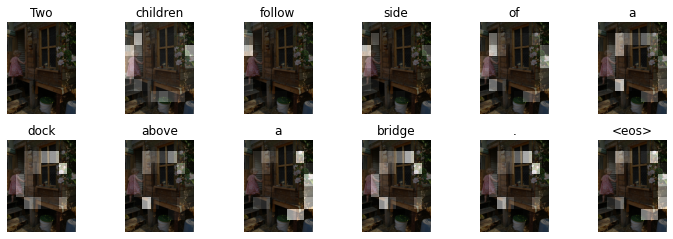

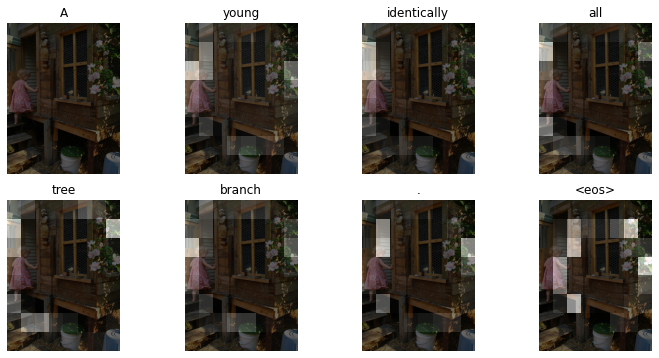

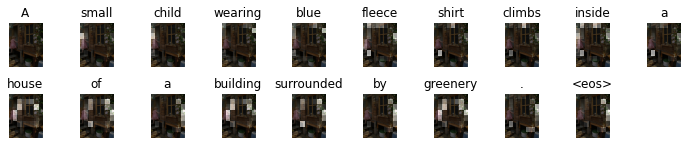

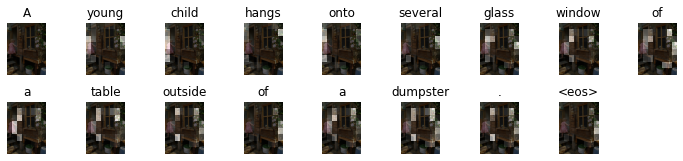

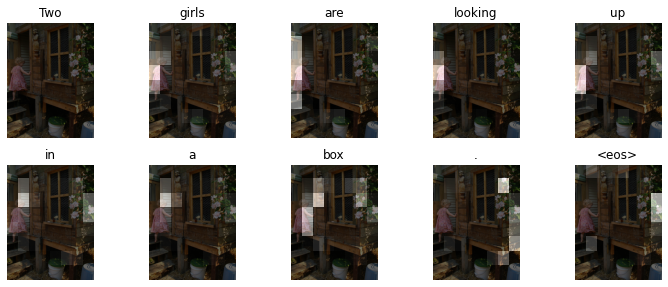

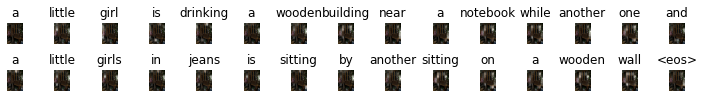

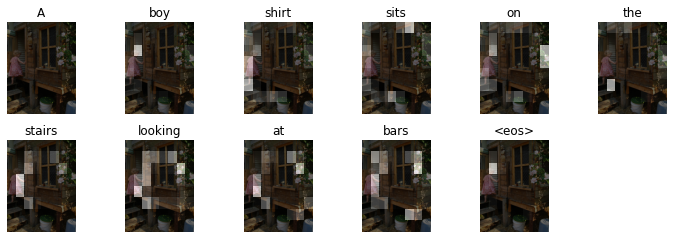

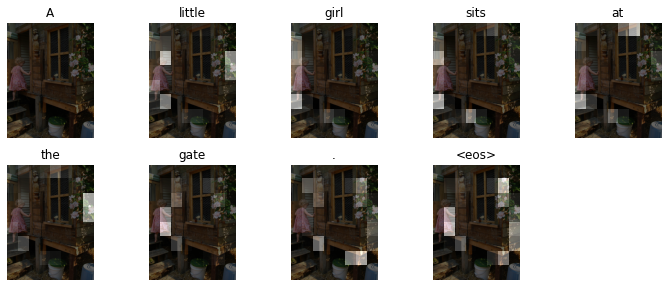

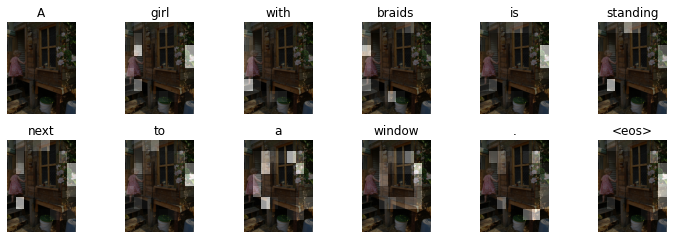

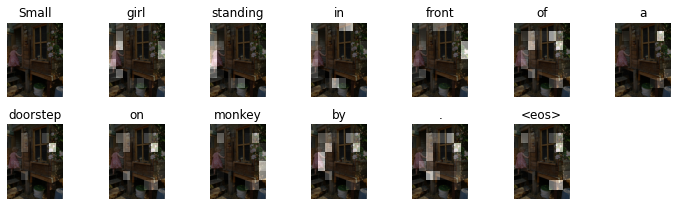

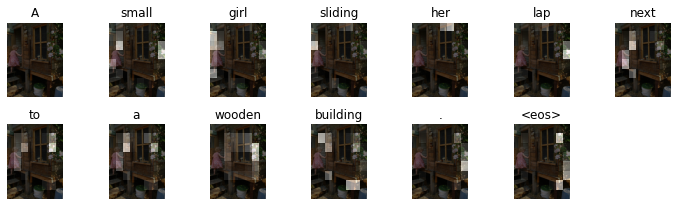

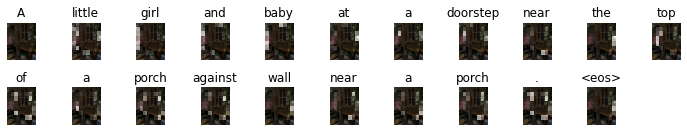

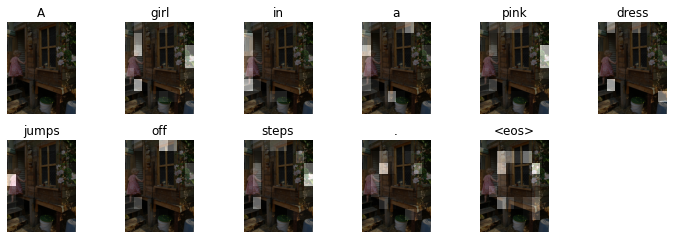

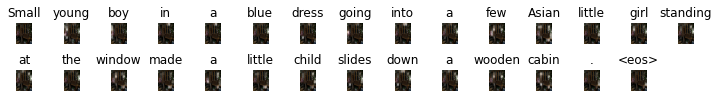

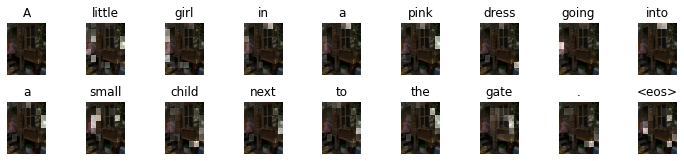

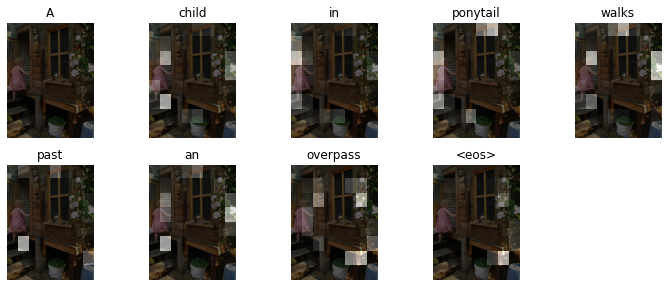

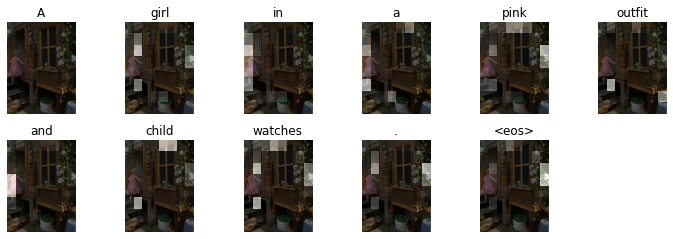

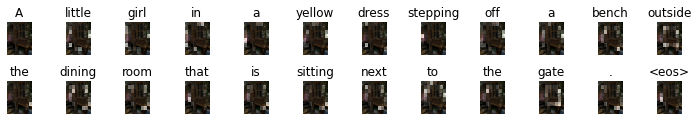

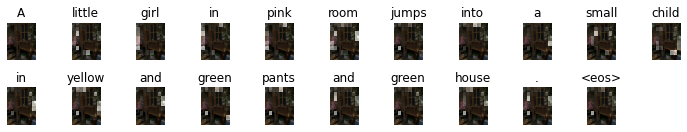

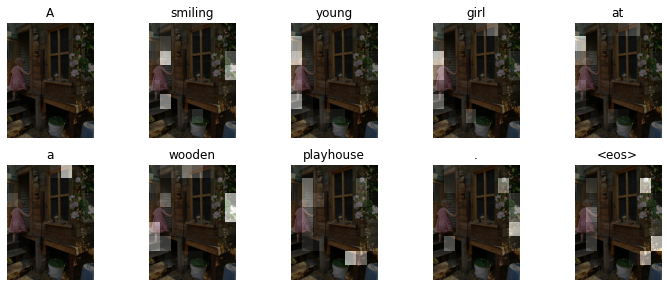

In [17]:
trainer.train(dataloader, epochs)

In [18]:
trainer.encoder.eval()
trainer.decoder.eval()

torch.save(trainer.encoder.state_dict(), "models/encoder.pt")
torch.save(trainer.decoder.state_dict(), "models/decoder.pt")